In [1]:
from lib.training import train, eval
from lib.data import get_data_chest_x_ray_image, get_chexpert
from lib.utils import get_device
from torch import nn 
import torch
import torch.optim as opt
import pandas as pd
from lib.models import MyResnet, MyMobileNet, MyDenseNet, MyViT

/home/matheusmartin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = get_device()

In [3]:
class ExperimentConfig:
    '''
    Classe que define as configurações de um experimento
    '''
    def __init__(self, name, model_fn, loss_fn, optimizer_fn, class_map=None, idx_to_class=None):
        self.name = name
        self.model_fn = model_fn
        self.loss_fn = loss_fn
        self.optimizer_fn = optimizer_fn
        self.class_map = class_map
        self.idx_to_class = idx_to_class

In [4]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from lib.data import TransformDataset
from lib.utils import plot_evolution, plot_confusion_matrix
from sklearn.metrics import classification_report

def load_only_model_state(checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
    return checkpoint['model_state_dict']

def generate_stat_dataframe(path_to_history : dict, save_name, device):
    '''
    Recebe o path para o local dos checkpoints (de todos os folds) do modelo e junta todos os histories em um dataframe.
    '''
    
    import torch
    from collections import defaultdict
    import pandas as pd
    
    cp_paths = os.listdir(path_to_history)
    cp_paths = [os.path.join(path_to_history, x) for x in cp_paths if '.pt' in x] ## filtering desirable file type
    cp_paths = [x for x in cp_paths if os.path.isfile(x)] ## filtering just files

    df_save_path = os.path.join(path_to_history, f'{save_name}.csv')
    df_data = defaultdict(list)

    for cp_path in cp_paths: 
        checkpoint = torch.load(cp_path, weights_only=False, map_location=device)
        history = checkpoint['metadata']['history']
        
        prefix, ext = os.path.splitext(cp_path)
        fold_number = int(prefix.split('fold=')[-1])
        
        columns = list(history.keys())
        for c in columns: df_data[c].extend(history[c])
        
        repeated_fold_list = [fold_number]*(len(history[columns[0]]))
        df_data['fold'].extend(repeated_fold_list)
        
    results_df = pd.DataFrame(data=df_data)
    results_df.to_csv(df_save_path)
    
    return results_df

def get_fold_of_best_model(results_df: pd.DataFrame, best_by='val_f1_score', best_by_mode='max'):
    '''
    Retorna os melhor modelo de acordo com os resultados do histório de treinamento presente no `results_df`.
    '''
    
    if best_by_mode == "max":
        best_idx = results_df[best_by].idxmax()
    elif best_by_mode == 'min':
        best_idx = results_df[best_by].idxmin()
    else:
        raise ValueError(f'best_by_mode `{best_by_mode}` is not valid')
    selected_fold = results_df.loc[best_idx, 'fold']
    return selected_fold

def prepare_dataloaders(*datasets, batch_size=64, shuffle=True):
    '''
    Recebe um número variável de datasets e retorna uma lista de dataloaders desses datasets na mesma ordem de entrada.
    '''
    num_workers = max(1, os.cpu_count() - 1)
    dataloader_list = []
    for dataset in datasets:
        new_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=True
        )
        dataloader_list.append(new_dataloader)
    return dataloader_list

def get_my_metrics(device, n_classes=2, task='multiclass'):
    '''
    Constroi a coleção de métricas que vai ser usada nos experimentos.
    '''
    import torchmetrics
    from lib.metrics import MetricCollection

    metrics = MetricCollection(device=device)

    if (task == 'multiclass') or (task == 'binary'):
        metrics.register('accuracy', torchmetrics.Accuracy(task='multiclass', num_classes=n_classes))
        metrics.register('precision', torchmetrics.Precision(task='multiclass', num_classes=n_classes, average='macro'))
        metrics.register('recall', torchmetrics.Recall(task='multiclass', num_classes=n_classes, average='macro'))
        metrics.register('f1_score', torchmetrics.F1Score(task='multiclass', num_classes=n_classes, average='macro'))

    elif task == 'multilabel':
        metrics.register('accuracy', torchmetrics.Accuracy(task='multilabel', num_labels=n_classes))
        metrics.register('precision', torchmetrics.Precision(task='multilabel', num_labels=n_classes, average='macro'))
        metrics.register('recall', torchmetrics.Recall(task='multilabel', num_labels=n_classes, average='macro'))
        metrics.register('f1_score', torchmetrics.F1Score(task='multilabel', num_labels=n_classes, average='macro'))

    else:
        raise ValueError(f"Task {task} does not exist. Use 'binary', 'multiclass' or 'multilabel'.")

    return metrics

### target_class --> 0, others --> 1
def get_binary_class_mapping_dict(old_id2class_map : dict, target_label):
    '''
    Recebe um dicionário com vários id's mapeados para os labels e retorna um dicionário em que mapeia os id's que não são iguais ao do target label par 0 
    e que são iguais para 1
    '''
    
    old_idx_to_new_idx = {k:(1 if target_label!= v else 0) for k,v in old_id2class_map.items()}
    new_idx_to_class = {0: target_label, 1 : f'not-{target_label}'}
    return old_idx_to_new_idx, new_idx_to_class
    

def generate_fold_plots(results_df: pd.DataFrame, target_columns, title, save_path=None, highlight=None):
    '''
    Função usada para gerar as curvas de loss dos modelos
    '''

    for fold in results_df['fold'].unique().tolist():
        fold_slice = results_df[results_df['fold'] == fold].reset_index(drop=True)
        column_values = [fold_slice[tc].tolist() for tc in target_columns]
        
        best_epochs = None
        if highlight is not None:      
            best_epochs = []
            for tc in target_columns:
                if highlight == 'max':
                    best_epochs.append(fold_slice[tc].values.argmax() + 1)
                elif highlight == 'min':
                    best_epochs.append(fold_slice[tc].values.argmin() + 1)
        
        if save_path is not None:
            os.makedirs(save_path, exist_ok=True)
            save_full_path = os.path.join(save_path, f'{title}_fold={fold}.png')
        else:
            save_full_path = None
        
        plot_evolution(
            y_values=column_values, 
            y_labels=target_columns, 
            title=title,
            xlabel='Epochs', 
            ylabel='Values', 
            path=save_full_path, 
            #vlines=best_epochs
        )    
        
    return 

def get_fold_number_from_path(path):
    '''
    Extrai o número do fold presente no nome do path
    '''
    prefix, ext = os.path.splitext(path)
    return int(prefix.split('fold=')[-1])

def test_folds_on_test(path_to_models, test_dataset, model_builder, device, idx_to_class_map, experiment_path=None, images_path=None):
    '''
    Testa todos os melhores modelos de cada fold no dataset de teste, reportando o classfication report e matriz de confusão.
    '''
    
    cp_paths = os.listdir(path_to_models)
    cp_paths = [os.path.join(path_to_models, x) for x in cp_paths if ('.pt' in x) and ('best' in x)] ## filtering desirable file type
    cp_paths = [x for x in cp_paths if os.path.isfile(x)] ## filtering just files   
    
    test_dataset = TransformDataset(test_dataset, transform=None)
    test_dataloader = prepare_dataloaders(test_dataset)[0] ## returns a list
    target_names = [idx_to_class_map[i] for i in sorted(idx_to_class_map.keys())]
        
    for cp_path in cp_paths:
        fold_number = get_fold_number_from_path(cp_path)
        
        model_state = load_only_model_state(cp_path, device)
        model = model_builder().to(device=device)
        model.load_state_dict(model_state)
        
        y_true, y_pred = eval(model, test_dataloader, device, task='multiclass')
    
        report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
        
        report_df = pd.DataFrame(report_dict)
        print(f'Classification Report Fold {fold_number}')
        print(report_df)
        
        if experiment_path:
            classification_report_path = os.path.join(experiment_path, f'classification_report_fold={fold_number}.csv')
            report_df.to_csv(classification_report_path)

        if images_path:
            cm_save_path = os.path.join(images_path, f'confusion_matrix_fold={fold_number}.png')     
        
        print(f'Confusion Matrix Fold {fold_number}')       
        plot_confusion_matrix(y_true, y_pred, class_map=idx_to_class_map, save_path=cm_save_path)
        
    return
        

def experiment(config : ExperimentConfig, data_dict, device, metrics, freeze=False, epochs=30, warmup=5, patience=10, mode='train', best_by='val_f1_score', best_by_mode='max'):
    '''
    Função que define um experimento.
    mode=train --> Treina vários modelos utilizando folds já construídos previamente e passados pelo data_dict salvando checkpoints para os melhores modelos de cada fold e o checkpoint ao final do treino.
    mode=results --> Gera confusion matrix, dataframe de resultados e plot de curvas de loss (loss de validação e treino) para todos os folds.
    mode=train+results --> executa sequencialmente os dois modos descritos anteriormente, na mesma ordem.
    '''
    
    save_path = f'experiments/{config.name}_folder'
    images_path = os.path.join(save_path, 'images/')
    
    os.makedirs(save_path, exist_ok=True)   
    os.makedirs(images_path, exist_ok=True)
    
    if mode == 'train' or mode == 'train+results':
        
        folds = data_dict['folds']
        base_dataset = data_dict['base_dataset']
        train_transform = data_dict['train_transform']
        test_transform = data_dict['test_transform']
        
        for fold_idx, (train_idx, val_idx) in enumerate(folds):
            print(f"\n--- Fold {fold_idx+1} ---")
            
            model = config.model_fn().to(device=device)
            
            if freeze: model.freeze()
            else : model.unfreeze()

            optimizer = config.optimizer_fn(model.parameters())
            loss_fn = config.loss_fn()
            
            train_subset = Subset(base_dataset, train_idx)
            val_subset = Subset(base_dataset, val_idx)

            train_dataset = TransformDataset(train_subset, train_transform, class_map=config.class_map)
            val_dataset = TransformDataset(val_subset, test_transform, class_map=config.class_map)
            
            train_dataloader, val_dataloader = prepare_dataloaders(train_dataset, val_dataset)
            
            save_name = f'{config.name}_fold={fold_idx+1}.pt'
            
            history, model = train(
                model, train_dataloader, val_dataloader,
                loss_fn, optimizer,
                save_path=save_path, save_name=save_name,
                device=device, metrics=metrics, verbose=True,
                epochs=epochs, warmup=warmup, patience=patience,
            )
            
    if mode == 'results' or mode == 'train+results':
        print('Generating results ...')
        
        ## constructing the results dataframe, such that it holds the information of all folds
        results_df = generate_stat_dataframe(save_path, f'{config.name}_results', device)  
        
        ## plotting loss evolution graphics
        generate_fold_plots(results_df, ['val_loss', 'train_loss'], 'Loss Evolution Plot', save_path=images_path, highlight='min')
                 
        print('Evaluating Folds on test dataset...')
        test_dataset = data_dict['test_dataset']
        idx_to_class = data_dict['idx_to_class']
        
        test_folds_on_test(save_path, test_dataset, config.model_fn, device, idx_to_class, save_path, images_path)
        
    else:
        raise ValueError(f'mode `{mode}` is not valid')

In [ ]:
data_dict = get_data_chest_x_ray_image(img_size=(224, 224), kfold=5)  
n_classes = len(data_dict['classes'])
metrics = get_my_metrics(device, n_classes=n_classes, task='multiclass')  

In [ ]:
resnet18_config = ExperimentConfig(
    name="resnet18",
    model_fn=lambda: MyResnet(resnet_version='resnet18', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(resnet18_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del resnet18_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
## resnet18 congelada
resnet18_freeze_config = ExperimentConfig(
    name="resnet18_freeze",
    model_fn=lambda: MyResnet(resnet_version='resnet18', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(resnet18_freeze_config, data_dict, device, metrics, freeze=True, epochs=50, mode='train+results')

del resnet18_freeze_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
resnet34_config = ExperimentConfig(
    name="resnet34",
    model_fn=lambda: MyResnet(resnet_version='resnet34', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(resnet34_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del resnet34_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
## resnet34 congelada
resnet34_freeze_config = ExperimentConfig(
    name="resnet34_freeze",
    model_fn=lambda: MyResnet(resnet_version='resnet34', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(resnet34_freeze_config, data_dict, device, metrics, freeze=True, epochs=50, mode='train+results')

del resnet34_freeze_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
mobilenet_v2_config = ExperimentConfig(
    name="mobilenet_v2",
    model_fn=lambda: MyMobileNet(mobilenet_version='mobilenet_v2', n_classes=2),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(mobilenet_v2_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del mobilenet_v2_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
mobilenet_v3_large_config = ExperimentConfig(
    name="mobilenet_v3_large",
    model_fn=lambda: MyMobileNet(mobilenet_version='mobilenet_v3_large', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(mobilenet_v3_large_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del mobilenet_v3_large_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
densenet121_config = ExperimentConfig(
    name="densenet121",
    model_fn=lambda: MyDenseNet(densenet_version='densenet121', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(densenet121_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del densenet121_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
densenet161_config = ExperimentConfig(
    name="densenet161",
    model_fn=lambda: MyDenseNet(densenet_version='densenet161', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(densenet161_config, data_dict, device, metrics, freeze=False, epochs=50, mode='train+results')

del densenet161_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
# Única rede treinada com 100 épocas, já que nos treinamentos era possível perceber que a rede não tinha convergido com 50 épocas.
vit_b_16_config = ExperimentConfig(
    name="vit_b_16",
    model_fn=lambda: MyViT(vit_version='vit_b_16', n_classes=3),
    loss_fn=lambda: nn.CrossEntropyLoss(),
    optimizer_fn=lambda params: opt.Adam(params, lr=1e-3),
    )      
experiment(vit_b_16_config, data_dict, device, metrics, freeze=False, epochs=100, mode='train+results')

del vit_b_16_config
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [16]:
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt
import seaborn as sns
from lib.data import get_chexpert
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman


def friedman_test_and_posthoc_nemenyi(experimentpath_modelname_list: list[str], target_column='val_f1_score', alpha=0.05, save_path=None):
    '''
    Executa o teste de friedman e, se significativo, o teste post-hoc de Nemenyi.
    Plota um diagrama de Critical Difference e um heatmap dos p-values.
    '''
    
    friedman_data_df = pd.DataFrame()
    model_name_list = []

    ## building friedman table
    for experiment_path, model_name in experimentpath_modelname_list:
        _dir = os.listdir(experiment_path)
        result_df_path = [x for x in _dir if 'results.csv' in x][-1]
        result_df_path = os.path.join(experiment_path, result_df_path)

        result_df = pd.read_csv(result_df_path)
        result_df_max = result_df.groupby('fold').max().reset_index()
        friedman_data_df[model_name] = result_df_max[target_column]
        model_name_list.append(model_name)

    stat, p_friedman = friedmanchisquare(*[friedman_data_df[col] for col in friedman_data_df.columns])
    print(f"Friedman Test - p-value: {p_friedman:.9f}")

    # Nemenyi posthoc (table + heatmap)
    if p_friedman < alpha:
        print("Diferença estatística significativa encontrada. Realizando o teste post-hoc de Nemenyi...")

        # Executar o teste de Nemenyi e obter a matriz de p-values
        nemenyi_p_values = posthoc_nemenyi_friedman(friedman_data_df)
        nemenyi_p_values.columns = model_name_list
        nemenyi_p_values.index = model_name_list

        print(nemenyi_p_values)
        if save_path:
            full_path_latex = os.path.join(save_path, 'posthoc_nemenyi_table.latex')
            full_path_csv = os.path.join(save_path, 'posthoc_nemenyi_table.csv')
            
            nemenyi_p_values.to_latex(full_path_latex)
            nemenyi_p_values.to_csv(full_path_csv)

        ## p-values heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(nemenyi_p_values, annot=True, cmap='viridis', fmt=".4f", cbar_kws={'label': 'p-value'})
        plt.title('Matriz de p-values do Teste Post-Hoc de Nemenyi', fontsize=15)
        plt.show()

    else:
        print("Nenhuma diferença estatística significativa encontrada. Não será executado o teste post-hoc.")

    # using autorank to plot critical difference diagram
    result = autorank(friedman_data_df, alpha=alpha, verbose=True)
    print(create_report(result))
    plot_stats(result)

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        full_path = os.path.join(save_path, 'critical_difference_diagram.png')
        plt.savefig(full_path, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()

    return
        

def generate_models_fold_comparison(
    experimentpath_modelname_list: list[str], 
    target_columns: list[str], 
    save_path=None, 
    save_name='models_fold_comparison'
):
    '''
    Função não é mais utilizada
    '''
    
    stats_list = []
    
    for experiment_path, model_name in experimentpath_modelname_list:
        _dir = os.listdir(experiment_path)
        result_df_path = [x for x in _dir if '.parquet' in x][-1]
        result_df_path = os.path.join(experiment_path, result_df_path)

        result_df = pd.read_parquet(result_df_path)
        
        stats = (
            result_df
            .groupby("fold")[target_columns]
            .agg(["mean", "std"])
        )
        
        stats = stats.stack(level=0).reset_index()          
        stats.rename(columns={"level_1": "metric"}, inplace=True)
        stats["model"] = model_name
        stats_list.append(stats)
        
    final_df = pd.concat(stats_list, axis=0, ignore_index=True)

    if save_path:
        save_file = os.path.join(save_path, f"{save_name}.csv")
        final_df.to_csv(save_file, index=False)
    
    return final_df


def generate_dataset_comparison_dataframe(model, test_dataset, model_classes, dataset_classes, device, save_path=None, save_name='dataset_comparison'):
    '''
    Testa um modelo em um conjunto de teste e cria um dataframe de comparação entre o que o modelo chutou com as classes do outro dataset.
    Se o mesmo dataset em que o modelo foi treinado for passado, o dataframe corresponde a uma matriz de confução.
    Ex.: se o modelo classicou uma amostra como classe A, e classe no dataset passado a amostra é X, um `hit` é considerado, e o par (A, X) é incrementado.
    '''
    
    test_dataloader = prepare_dataloaders(test_dataset, batch_size=64, shuffle=True)[0]   
     
    y_true, y_pred = eval(model, test_dataloader, device=device, task='multiclass')

    comparison_df = pd.DataFrame(data=0, columns=range(len(dataset_classes)), index=range(len(model_classes)))
    
    print(f'Total Number of Predictions : {len(y_pred)}')
    for yt, yp in tqdm((zip(y_true, y_pred))):
        yp_label = int(yp)
        if isinstance(yt, list) or isinstance(yt, np.ndarray):
            comparison_df.iloc[yp_label, [idx for idx, x in enumerate(yt) if int(x) == 1]] += 1
        else:
            comparison_df.iloc[yp_label, yt] += 1

    comparison_df.index = model_classes
    comparison_df.columns = dataset_classes
    
    if save_path:
        full_save_path_csv = os.path.join(save_path, f'{save_name}.csv')
        full_save_path_latex = os.path.join(save_path, f'{save_name}.latex')
        comparison_df.to_csv(full_save_path_csv)
        comparison_df.to_latex(full_save_path_latex)
        
    print(comparison_df)
        
    return comparison_df


def generate_dataset_comparison_heat_map(comparison_df, title, save_name='dataset_comparison_heatmap', save_path=None):
    '''
    Transforma o dataframe de comparação de dataset em um heatmap
    '''
    
    plt.figure(figsize=(15, 10))
    plt.title(title)
    
    sns.heatmap(comparison_df.T, annot=True, cmap='viridis', fmt="d")
    
    if save_path:
        full_save_path = os.path.join(save_path, f'{save_name}.png')
        plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()
    
    return

def plot_covid_chestxray_metadata_age_histogram(path, title, save_name='chestxray_age_histogram', save_path=None):
    '''
    Plota histograma de idade dos metadados do chestxray
    '''
    
    metadata = pd.read_csv(path)
    metadata = metadata.dropna(subset=['age'])
    
    sns.histplot(data=metadata, x="age")
    plt.title(title)
    
    if save_path:
        full_save_path= os.path.join(save_path, f'{save_name}.png')
        plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()
    
    return
    
def plot_chexpert_age_histogram(title, save_name='chexpert_age_histogram', save_path=None):
    '''
    Plota histograma de idade dos metadados do chexpert
    '''
    
    chexpert_data = get_chexpert()
    
    df_train = chexpert_data['df_train']
    df_valid = chexpert_data['df_valid']
    
    age_column = 'Age'
    
    age_dataframe = pd.DataFrame(columns=[age_column])
    age_dataframe = pd.concat([age_dataframe, df_train[age_column], df_valid[age_column]], axis='index').reset_index(drop=True)
    
    below_18_number = (age_dataframe[age_column] < 18).astype(int).sum()
    below_or_equal_18_number = (age_dataframe[age_column] <= 18).astype(int).sum()
    max_age = age_dataframe[age_column].max()
    
    print(f'Number of people with less than 18 years {below_18_number}')
    print(f'Number of people with 18 years or less : {below_or_equal_18_number}')
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=age_dataframe, x=age_column, bins=30)
    plt.title(title)
    plt.xlabel('Idade')
    plt.ylabel('Total')
    plt.xlim((17, max_age + 5))
    
    if save_path:
        full_save_path = os.path.join(save_path, f'{save_name}.png')
        plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()
    
    return

def get_last_conv_layer(model: nn.Module):
    for layer in reversed(list(model.modules())):
        if isinstance(layer, nn.Conv2d):
            return layer
    raise ValueError("No Conv2d layer found in the model.")


def plot_grad_cam_examples(model, device):
    '''
    Gera uma figura de análise com grad cam em duas amostras No Finding, porém uma foi classificada corretamente como Normal e outra não.
    '''
    from lib.data import CheXpertDataSet, get_transformations
    from lib.utils import show_batch
    from tqdm import tqdm
    
    chexpert_dict = get_chexpert()
    chest_x_ray_dict = get_data_chest_x_ray_image()
    
    df_train = chexpert_dict['df_train']
    just_no_finding = df_train[df_train['No Finding'] == 1]
    
    _, test_transform = get_transformations()
    
    no_finding_dataset = CheXpertDataSet(just_no_finding, chexpert_dict['classes'], 'Path', transformation=test_transform)
    
    ## é no finding e preveu normal e é no finding mas não preveu normal
    right_example = None
    wrong_example = None
    
    no_finding_y_tensor = torch.zeros(len(chexpert_dict['classes']), dtype=torch.long)
    no_finding_idx = chexpert_dict['class_to_idx']['No Finding']
    no_finding_y_tensor[no_finding_idx] = 1
    
    no_finding_y_tensor = no_finding_y_tensor.to(device)
    
    model.eval()
    with torch.no_grad():
        for x,y in tqdm(no_finding_dataset, desc="Finding examples"):
            x,y = x.to(device), y.long().to(device)
            
            if x.dim() == 3:
                x = x.unsqueeze(0)  ## modelo só aceita batchs, transforma em batch de uma amostra
            
            logits = model(x)
            pred_class_idx = torch.argmax(logits, dim=1).item()
            original_class = chest_x_ray_dict['idx_to_class'][pred_class_idx]

            if original_class == 'NORMAL' and torch.equal(y, no_finding_y_tensor):
                right_example = (x, y)
            elif original_class != 'NORMAL' and torch.equal(y, no_finding_y_tensor):
                wrong_example = (x, y)
        
            if (right_example is not None) and (wrong_example is not None):
                break
    
    print('Found!. Plotting ...')
    
    right_image, right_label = right_example
    wrong_image, wrong_label = wrong_example
    images_to_plot = torch.cat([right_image, wrong_image], dim=0)
    
    show_batch(
        title="",
        images=images_to_plot,
        true_labels_list=['No Finding', 'No Finding'],
        pred_label_map=chest_x_ray_dict['idx_to_class'],
        device=device,
        net=model,
        grad_cam=True,
        target_layer=get_last_conv_layer(model),
        path='grad_cam_prediction_example.png',
    )
    
    return 


In [17]:
experimentpath_modelname_list = [
    ('experiments/resnet18_folder/', 'resnet18'),
    ('experiments/resnet34_folder/', 'resnet34'),
    ('experiments/mobilenet_v2_folder/', 'mobilenet v2'),
    ('experiments/mobilenet_v3_large_folder/', 'mobilenet v3 large'),
    ('experiments/densenet121_folder/', 'densenet121'),
    ('experiments/densenet161_folder/', 'densenet161'),
    ('experiments/resnet18_freeze_folder/', 'resnet18 frozen'),
    ('experiments/resnet34_freeze_folder/', 'resnet34 frozen'),
    ('experiments/vit_b_16_folder/', 'ViT b 16'),
]

Friedman Test - p-value: 0.000042950
Diferença estatística significativa encontrada. Realizando o teste post-hoc de Nemenyi...
                    resnet18  resnet34  mobilenet v2  mobilenet v3 large  \
resnet18            1.000000  1.000000      0.903592            0.998888   
resnet34            1.000000  1.000000      0.965588            0.999946   
mobilenet v2        0.903592  0.965588      1.000000            0.998888   
mobilenet v3 large  0.998888  0.999946      0.998888            1.000000   
densenet121         0.965588  0.903592      0.212625            0.650119   
densenet161         0.163935  0.091822      0.001746            0.023034   
resnet18 frozen     0.726718  0.569454      0.047673            0.270180   
resnet34 frozen     0.903592  0.796027      0.123891            0.488170   
ViT b 16            0.163935  0.091822      0.001746            0.023034   

                    densenet121  densenet161  resnet18 frozen  \
resnet18               0.965588     0.163935   

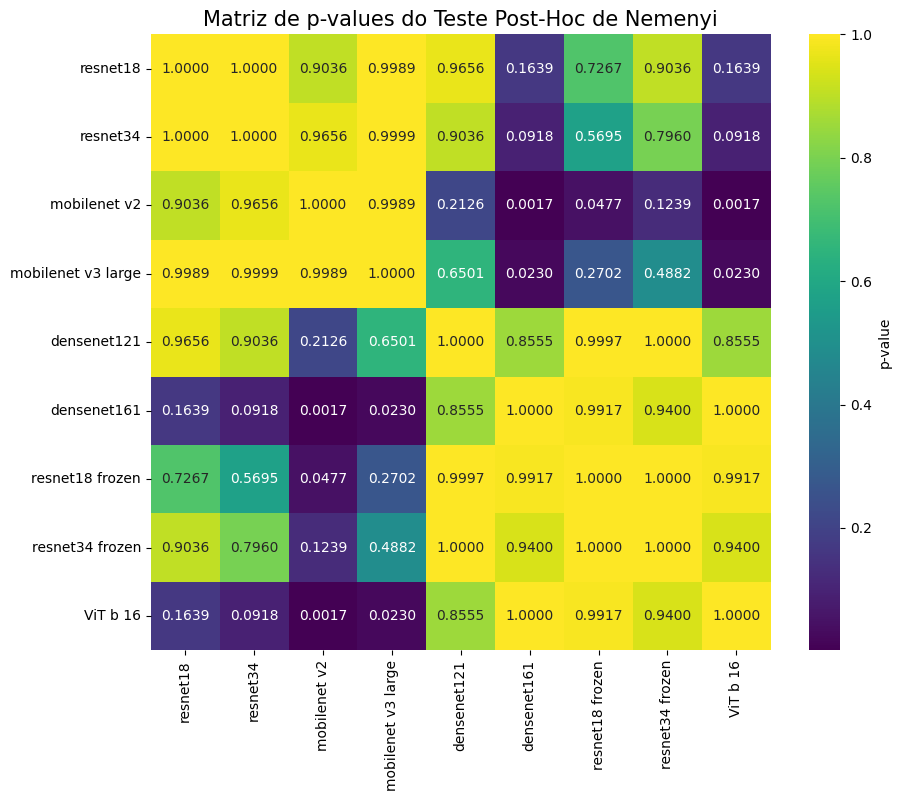

Fail to reject null hypothesis that data is normal for column resnet18 (p=0.283006>=0.005556)
Fail to reject null hypothesis that data is normal for column resnet34 (p=0.733993>=0.005556)
Fail to reject null hypothesis that data is normal for column mobilenet v2 (p=0.595736>=0.005556)
Fail to reject null hypothesis that data is normal for column mobilenet v3 large (p=0.278818>=0.005556)
Fail to reject null hypothesis that data is normal for column densenet121 (p=0.280460>=0.005556)
Fail to reject null hypothesis that data is normal for column densenet161 (p=0.094620>=0.005556)
Fail to reject null hypothesis that data is normal for column resnet18 frozen (p=0.452943>=0.005556)
Fail to reject null hypothesis that data is normal for column resnet34 frozen (p=0.161676>=0.005556)
Fail to reject null hypothesis that data is normal for column ViT b 16 (p=0.468590>=0.005556)
Using Bartlett's test for homoscedacity of normally distributed data
Rejecting null hypothesis that all variances are eq

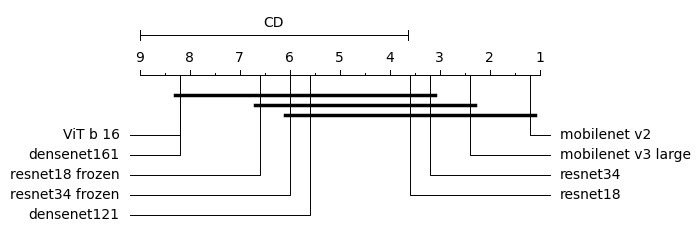

In [18]:
friedman_test_and_posthoc_nemenyi(experimentpath_modelname_list, alpha=0.05, save_path='./')

In [ ]:
## Melhor modelo foi mobilenet v2 e é o que será testado no outro dataset

chexpert_dict = get_chexpert()
chest_x_ray_dict = get_data_chest_x_ray_image()

path_to_mobilenet_v2 = 'experiments/mobilenet_v2_folder/'
results_path = os.path.join(path_to_mobilenet_v2, 'mobilenet_v2_results.csv')
mobilenet_v2_results = pd.read_csv(results_path)

## Selecionando melhor modelo entre os melhores modelos de cada fold para o teste.
fold = get_fold_of_best_model(mobilenet_v2_results, best_by='val_f1_score', best_by_mode='max')
print(f'Best Fold of `mobilenet v2`: {fold}, loading best model of fold 4 ...')

mobilenet_v2_str = 'mobilenet_v2'
checkpoint_path = os.path.join(path_to_mobilenet_v2, f'best_{mobilenet_v2_str}_fold={fold}.pt')

## Carregando modelo 
model_state = load_only_model_state(checkpoint_path, device)
mobilenet_v2_model = MyMobileNet(mobilenet_version=mobilenet_v2_str, n_classes=3).to(device)
mobilenet_v2_model.load_state_dict(model_state)

/home/matheusmartin/Desktop/2025-1-P2-classificador-CheXpert/lib/data.py:174: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[c] = df_train[c].replace(data_dict[c]['label2id'])


Best Fold of `mobilenet v2`: 4, loading best model of fold 4 ...


<All keys matched successfully>

In [127]:
## Testando na outra base
dataset_comparison_df = generate_dataset_comparison_dataframe(mobilenet_v2_model, chexpert_dict['train_dataset'], chest_x_ray_dict['classes'],
                                      chexpert_dict['classes'], device, './', 'dataset_comparison')

Total Number of Predictions : 191027


191027it [01:08, 2796.79it/s]


           No Finding  Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  \
COVID19         16748                        9100         23163         93325   
NORMAL            133                           8             6            84   
PNEUMONIA          93                          79           216           802   

           Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
COVID19           6941  49355          12845       4635        29508   
NORMAL              13      5              9         12           19   
PNEUMONIA           86    315            129         28          193   

           Pneumothorax  Pleural Effusion  Pleural Other  Fracture  \
COVID19           17409             76092           2479      7366   
NORMAL               39                52              4        12   
PNEUMONIA           245               755             22        58   

           Support Devices  
COVID19             106133  
NORMAL                 118  
PNEUMONIA         

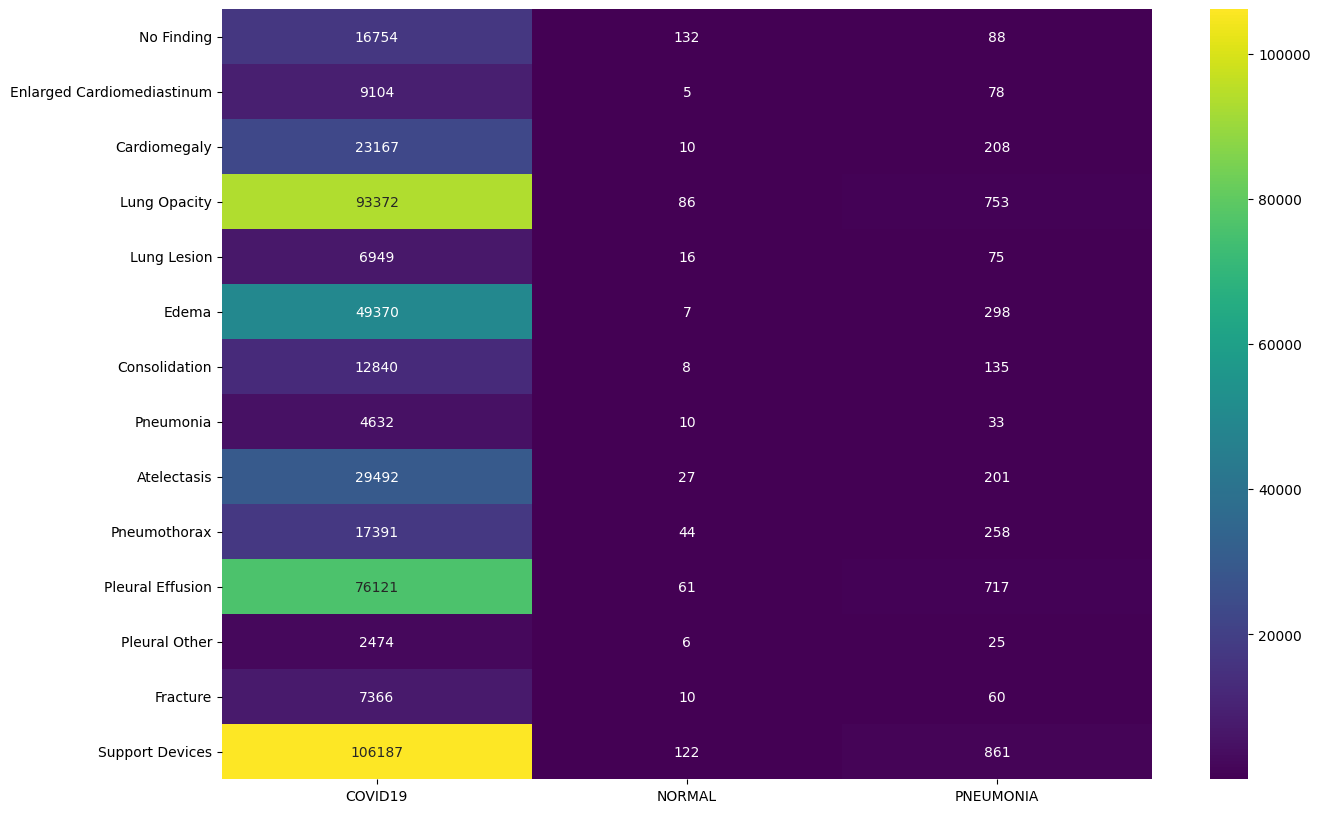

In [123]:
generate_dataset_comparison_heat_map(dataset_comparison_df, title='', save_name='dataset_comparison_heatmap', save_path='./')

/home/matheusmartin/Desktop/2025-1-P2-classificador-CheXpert/lib/data.py:174: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[c] = df_train[c].replace(data_dict[c]['label2id'])
Finding examples:   0%|          | 56/16974 [00:00<02:06, 133.68it/s]


Found!. Plotting ...


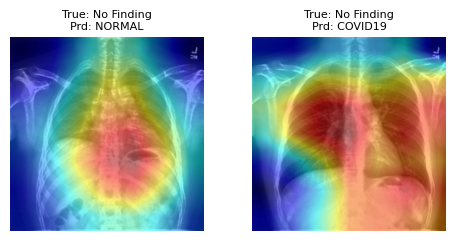

In [9]:
plot_grad_cam_examples(mobilenet_v2_model, device)

/home/matheusmartin/Desktop/2025-1-P2-classificador-CheXpert/lib/data.py:174: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[c] = df_train[c].replace(data_dict[c]['label2id'])


Number of people with less than 18 years 3
Number of people with 18 years or less : 666


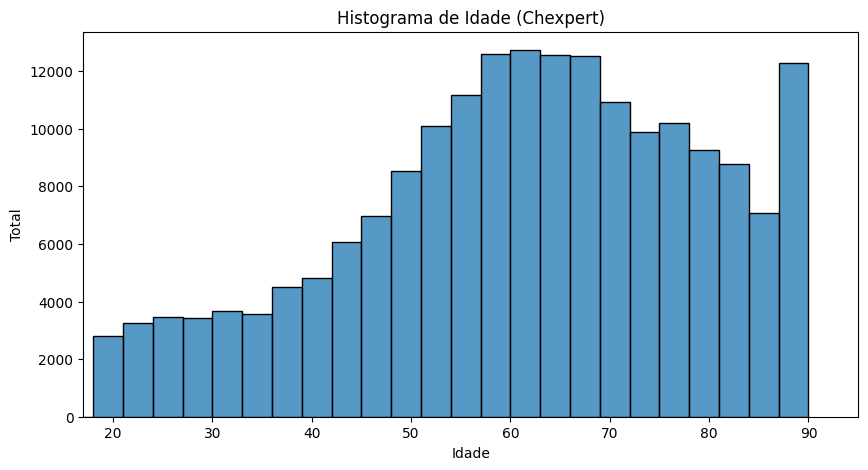

In [18]:
plot_chexpert_age_histogram('Histograma de Idade (Chexpert)', save_path='./')